In [12]:
%env KERAS_BACKEND = tensorflow
%env matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential, Model,load_model
from keras.layers import Input
from keras.layers import Dense,Activation,Lambda,concatenate
from keras.optimizers import SGD

from keras.datasets import mnist

from keras.utils import np_utils
from keras import metrics

from keras import backend as K

(x_train,y_train),(x_test,y_test) =mnist.load_data()

x_train = x_train.reshape(60000,784)
x_test =x_test.reshape(10000,784)

# 784 -> 100 -> 2(mean)    → 常態抽樣(lambda for sampling)　-> 2 -> 100 -> 784
#            -> 2(log_var) ↗　

x_train = x_train/255
x_test = x_test/255

enc_1 = Dense(100,activation='sigmoid')
enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(100,activation='sigmoid')
dec_1 = Dense(784,activation='sigmoid')

x = Input(shape=(784,))
enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

def sampling(args):
    z_mean,z_log_var = args
    epsilon = K.random_normal(shape=(2,),mean=0,stddev=1)
    return z_mean + K.exp(z_log_var/2)*epsilon

z = Lambda(sampling,output_shape=(2,))([z_mean,z_log_var])

dec_x = dec_2(z)
x_reconstructed = dec_1(dec_x)

VAE = Model(x,x_reconstructed)
VAE.summary()

def vae_loss(x,x_recon):
    
    #圖的重建
    recovery_loss = 784 * metrics.binary_crossentropy(x,x_recon)
    
    # 越像標準常態分配越好
    k1_loss = -0.5*K.sum(1+z_log_var-K.square(z_mean)-K.exp(z_log_var),axis=-1)
    
    return recovery_loss + k1_loss

VAE.compile(loss=vae_loss,optimizer='Nadam')

#VAE.fit(x_train,x_train,batch_size=32,epochs=100)

VAE.load_weights('VAE_handwriting_model_weights.h5')

env: KERAS_BACKEND=tensorflow
env: matplotlib=inline
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 784)          0                                            
__________________________________________________________________________________________________
dense_51 (Dense)                (None, 100)          78500       input_10[0][0]                   
__________________________________________________________________________________________________
dense_52 (Dense)                (None, 2)            202         dense_51[0][0]                   
__________________________________________________________________________________________________
dense_53 (Dense)                (None, 2)            202         dense_51[0][0]                   
_______________________________________

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_52 (Dense)             (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________
Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_54 (Dense)             (None, 100)               300       
____________________________________

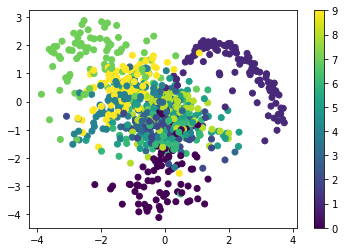

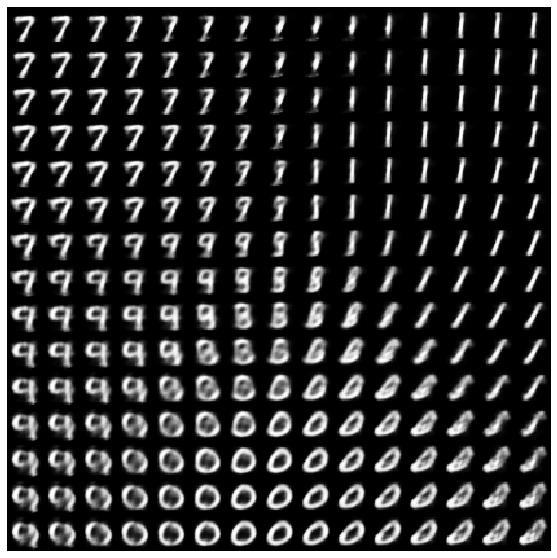

In [20]:
VAE_Encoder = Model(x,z_mean)
VAE_Encoder.summary()

h_input = Input(shape=(2,))
VAE_Decoder = Model(h_input,dec_1(dec_2(h_input)))
VAE_Decoder.summary()

# visualize encoder

idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的latent 表示為 %s"%(idx,VAE_Encoder.predict(x_train[idx:idx+1])))
idices = np.random.randint(x_test.shape[0],size=1000)

latents = VAE_Encoder.predict(x_test[idices])
plt.scatter(latents[:,0],latents[:,1],c=y_test[idices])
plt.colorbar()
plt.show()

def normalize_to_unit(x):
    x-=x.min()
    x/=x.max()
    return x

n=15
digit_size=28
grid_x = np.linspace(-4+0.05,4-0.05,n)
grid_y = np.linspace(-4+0.05,4-0.05,n)
figure = np.zeros((digit_size*n,digit_size*n))

for i,yi in enumerate(grid_x):
    for j,xi in enumerate(grid_y):
        z_sample = np.array([[xi,yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size,digit_size)
        figure[(n-i-1)*digit_size:(n-i)*digit_size,j*digit_size:(j+1)*digit_size]=normalize_to_unit(digit)
        
plt.figure(figsize=(10,10))
plt.imshow(figure,cmap='Greys_r')
plt.axis('off')
plt.show()


# 此 手寫辨識的 case中
# autoencoder 壓縮後亂放可還原就好
# VAE 會考慮到降維後的資料